# **Bandit Problems**

## Abstract

Bandit problem is a classic problem in reinforcement learning. To solve this problem, we will use various basic reinforcement learning algorithms which are thomphson sampling, $\epsilon$-greedy, UCB and random sampling. In this notebook, we're trying to figure out how those algorithms work, what factors will affect their performance and how much those factors will affect them.

## Setup

### 1.   Define environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary = True
class Bandit():
    def __init__(self, arm_count):
        """
        Multi-armed bandit with rewards 1 or 0.

        At initialization, multiple arms are created. The probability of each arm
        returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
        chosen from Uniform(0,1) at initialization
        """
        self.arm_count = arm_count
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary = stationary

    def generate_thetas(self):
        self.thetas = np.random.uniform(0, 1, self.arm_count)

    def get_reward_regret(self, arm):
        """ Returns random reward for arm action. Assumes actions are 0-indexed
        Args:
          arm is an int
        """
        self.timestep += 1
        if (self.stationary == False) and (self.timestep % 100 == 0):
            self.generate_thetas()
        # Simulate bernouilli sampling
        sim = np.random.uniform(0, 1, self.arm_count)
        rewards = (sim < self.thetas).astype(int)
        reward = rewards[arm]
        regret = self.thetas.max() - self.thetas[arm]

        return reward, regret

### 2.   Implementing algorithms



*   Thomphson Sampling



In [ ]:
class BetaAlgo():
    """
    The algos try to learn which Bandit arm is the best to maximize reward.

    It does this by modelling the distribution of the Bandit arms with a Beta,
    assuming the true probability of success of an arm is Bernouilli distributed.
    """

    def __init__(self, bandit):
        """
        Args:
          bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward


class BernGreedy(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'beta-greedy'

    def get_action(self):
        """ Bernouilli parameters are the expected values of the beta"""
        theta = self.alpha / (self.alpha + self.beta)
        return theta.argmax()


class BernThompson(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson'

    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()



*   $\epsilon$-greedy




In [ ]:
epsilon = 0.1
class EpsilonGreedy():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """

    def __init__(self, bandit):
        global epsilon
        self.epsilon = epsilon
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count)  # q-value of actions
        self.N = np.zeros(self.arm_count)  # action count

    @staticmethod
    def name():
        return 'epsilon-greedy'

    def get_action(self):
        if np.random.uniform(0, 1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1  # increment action count
        self.Q[arm] += 1 / self.N[arm] * (reward - self.Q[arm])  # inc. update rule



*    Upper Confidence Bound (UCB)



In [ ]:
ucb_c = 2
class UCB():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """

    def __init__(self, bandit):
        global ucb_c
        self.ucb_c = ucb_c
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count)  # q-value of actions
        self.N = np.zeros(self.arm_count) + 0.0001  # action count
        self.timestep = 1

    @staticmethod
    def name():
        return 'ucb'

    def get_action(self):
        ln_timestep = np.log(np.full(self.arm_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep / self.N)
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1  # increment action count
        self.Q[arm] += 1 / self.N[arm] * (reward - self.Q[arm])  # inc. update rule



*   Random sampling



In [ ]:
class RandomSampling:
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count

    @staticmethod
    def name():
        return 'random sampling'

    def get_action(self):
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

### 3.   Simulation and plotting results
In this part, I added a variable "title2" to represent the chart's title and changed the original variable "title" which works as legends' title to "title1".

In [ ]:
def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')


def multi_plot_data(data, names, title1='', title2=''):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10, title=title1)
    ax.set_title(title2)
    plt.show()


def simulate(simulations, timesteps, arm_count, Algorithm):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(arm_count)
        algo = Algorithm(bandit)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
        sum_regrets += regrets
    mean_regrets = sum_regrets / simulations
    return mean_regrets

## Experiments
To have a clearer look on the results, the charts I show below is all running at PyCharm.

### 1.   Baseline
In the first experiment, we're going to have a rough look on those algorithms by standard setup (epsilon=0.1, ubc=2).

In [ ]:
def experiment(arm_count=10, timesteps=1000, simulations=1000):
    """
    Standard setup across all experiments
    Args:
      timesteps: (int) how many steps for the algo to learn the bandit
      simulations: (int) number of epochs
    """
    algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

In [ ]:
experiment()

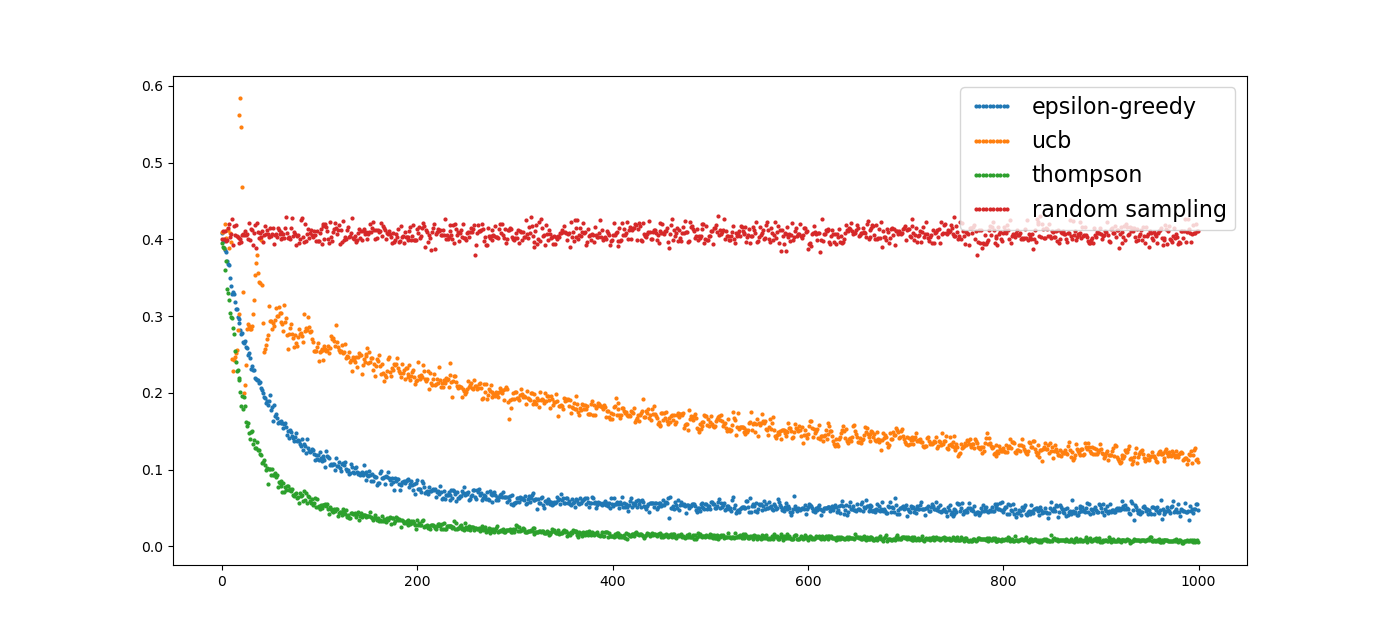

### 2.   Hyperparameters
Hyperparameter is the parameter that we should set before running. 

In [ ]:
def experiment1(arm_count=10, epsilons=None, timesteps=1000, simulations=1000):
    if epsilons is None:
        epsilons = [0, 0.01, 0.1, 0.5]
    algo = EpsilonGreedy
    global epsilon
    regrets = []
    names = []
    for e in epsilons:
        epsilon = e
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(e)
    multi_plot_data(regrets, names, title2='e-greedy with different epsilon')


def experiment2(arm_count=10, ucb_cs=None, timesteps=1000, simulations=1000):
    if ucb_cs is None:
        ucb_cs = [0, 0.1, 2]
    algo = UCB
    global ucb_c
    regrets = []
    names = []
    for c in ucb_cs:
        ucb_c = c
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(c)
    multi_plot_data(regrets, names, title2='UCB with different c')

In [ ]:
experiment1()
experiment2()



*   Thomphson Sampling


> In thomphson sampling, the parameter we can set before running is the prior distribution of each arm's reward. And it's illustrated at section 6 : TS with non-Beta distribution.






*   $\epsilon$-greedy

> For $\epsilon$-greedy, the hyperparameter matters is epsilon which is the probability of doing a random action selection (exploration). It is important because it represents the fundamental idea of e-greedy—the degree of exploration. As shown below, if e-greedy agents do not explore (epsilon = 0), their regret will not decrease. If they explore too much (epsilon = 0.5), they will end up with higher regret. If they become too greedy (epsilon = 0.01), they will have longer convergence time. 




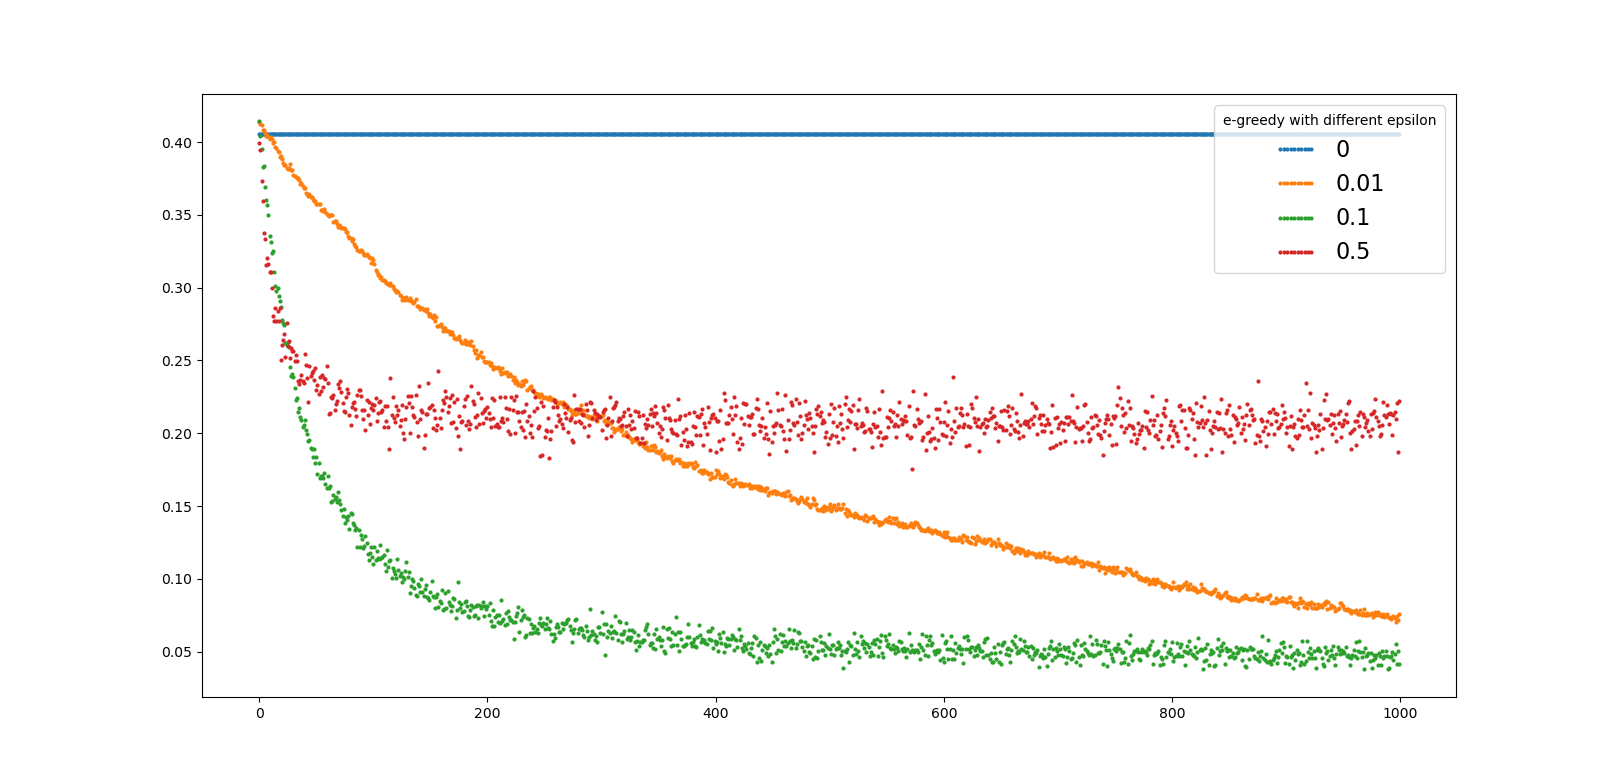



*    Upper Confidence Bound (UCB)

> In UCB, the hyperparameter matters is confidence c which also control the degree of exploration but in a different way from e-greedy. The confidence c represents how optimistic do agents think about the potential of those actions. As shown below UCB agents’ performance varied a lot with different hyperparameter confidence c. If agents are too optimistic (c =2), they will converge very slow, since they are more likely to explore other uncertain actions.





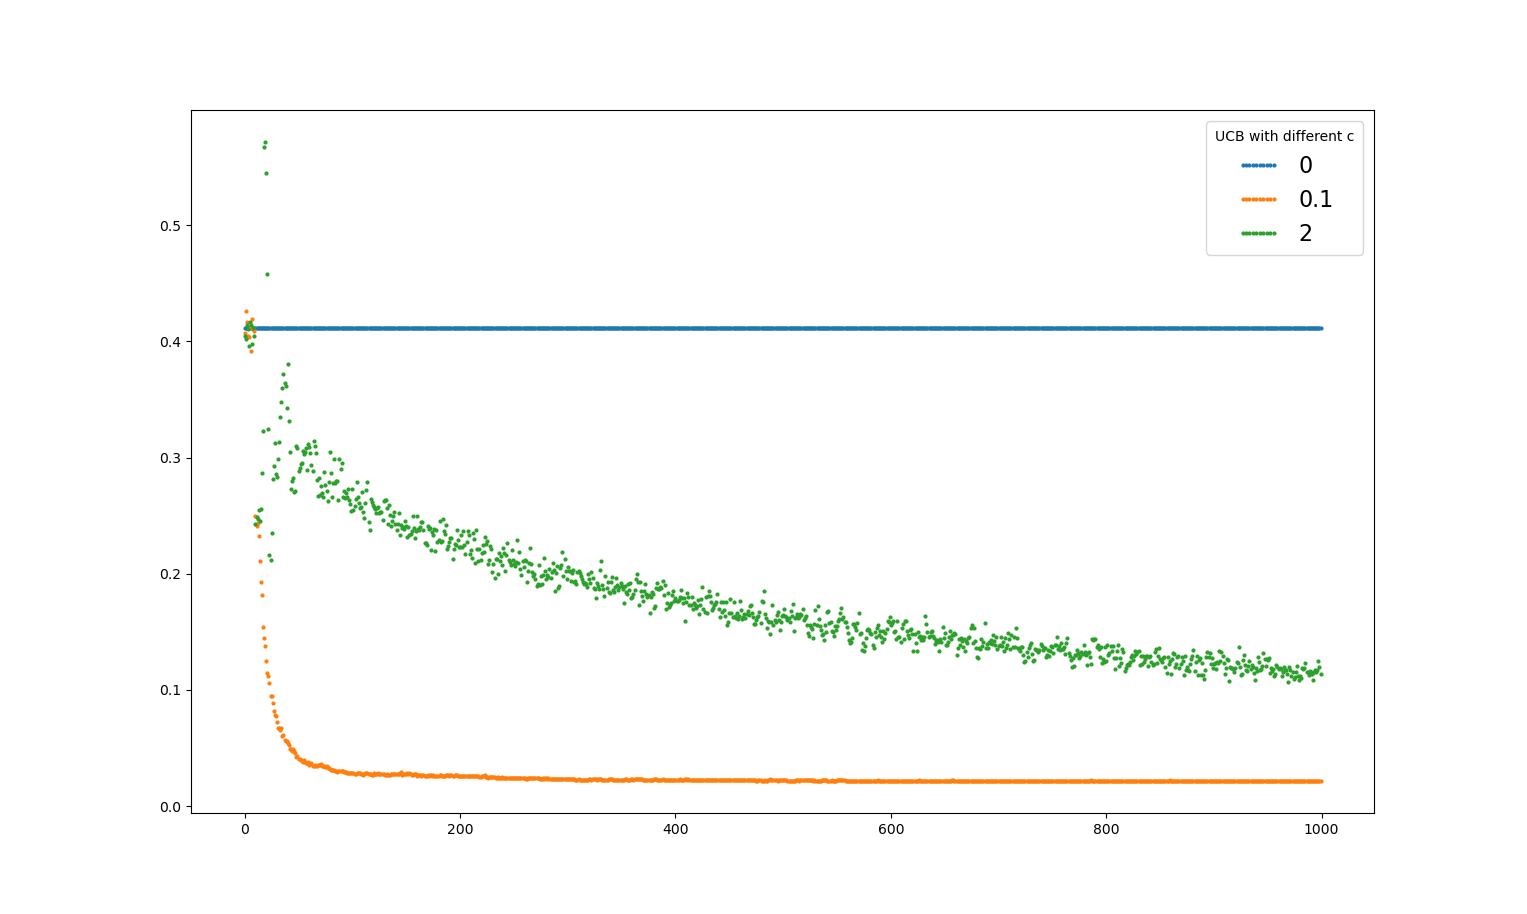



*   Random sampling


> There is no hyperparameter for random sampling because it just simply chooses actions randomly.




### 3.   Action space
In bandit problem, the action space is the number of arms in bandit, so I will experiment algorithms with different numbers of arms (10, 50, 200) to figure out how does the action space affect those algorithms.

In [ ]:
def experiment3(arm_counts=None, algos=None, timesteps=3000, simulations=1000):
    global ucb_c
    if algos is None:
        algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
    if arm_counts is None:
        arm_counts = [10, 50, 200]
    for algo in algos:
        regrets = []
        names = []
        if algo == UCB:
            for c in [2, 0.01]:
                ucb_c = c
                for arm_count in arm_counts:
                    regrets.append(simulate(simulations, timesteps, arm_count, algo))
                    names.append(arm_count)
                multi_plot_data(regrets, names, 'Number of arms', 'c=' + str(ucb_c))
                regrets.clear()
                names.clear()
        else:
            for arm_count in arm_counts:
                regrets.append(simulate(simulations, timesteps, arm_count, algo))
                names.append(arm_count)
            multi_plot_data(regrets, names, 'Number of arms')

In [ ]:
experiment3()



*   Thomphson Sampling

> As shown below, when action space becomes larger (increase number of arms), TS converges more slowly, since there are more actions to explore, but they will all converge to a close result at step 3000 (increase timestep from 1000 to 3000 to see the eventual converged result).



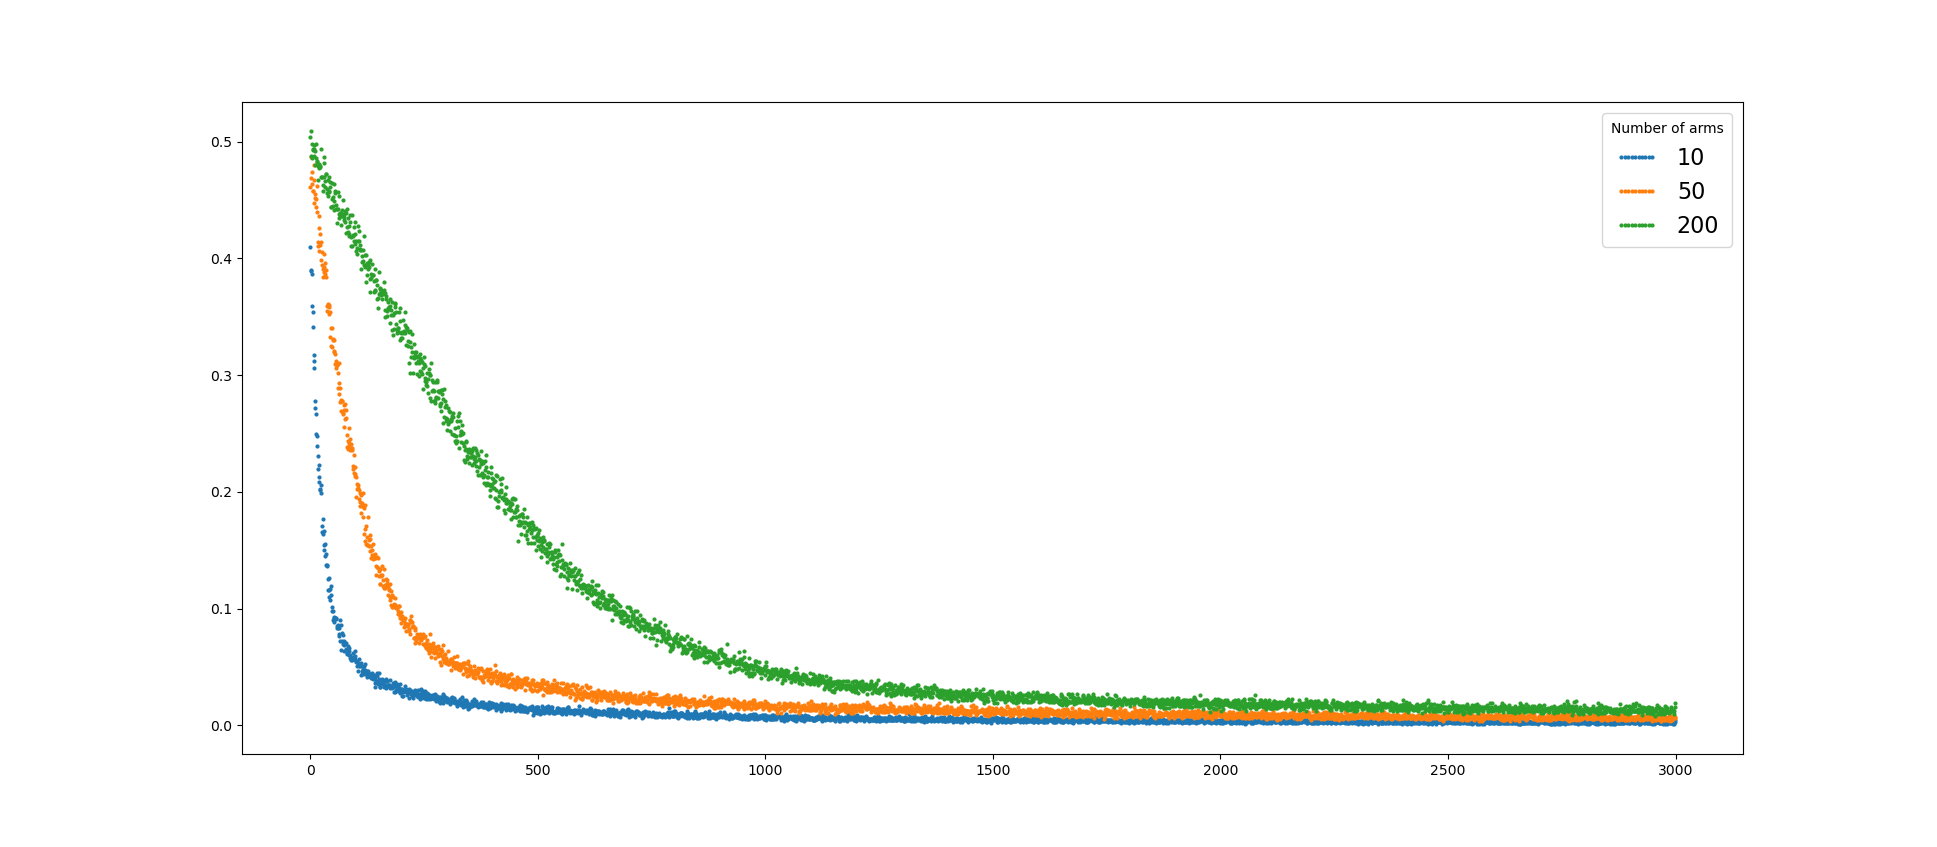

*   $\epsilon$-greedy


> As shown below, when action space becomes larger (increase number of arms), the convergence time of e-greedy does not change much. Since e-greedy does not focus on exploration to get the optimal action, it can only sample from a few actions and select the best at present to keep a low regret.




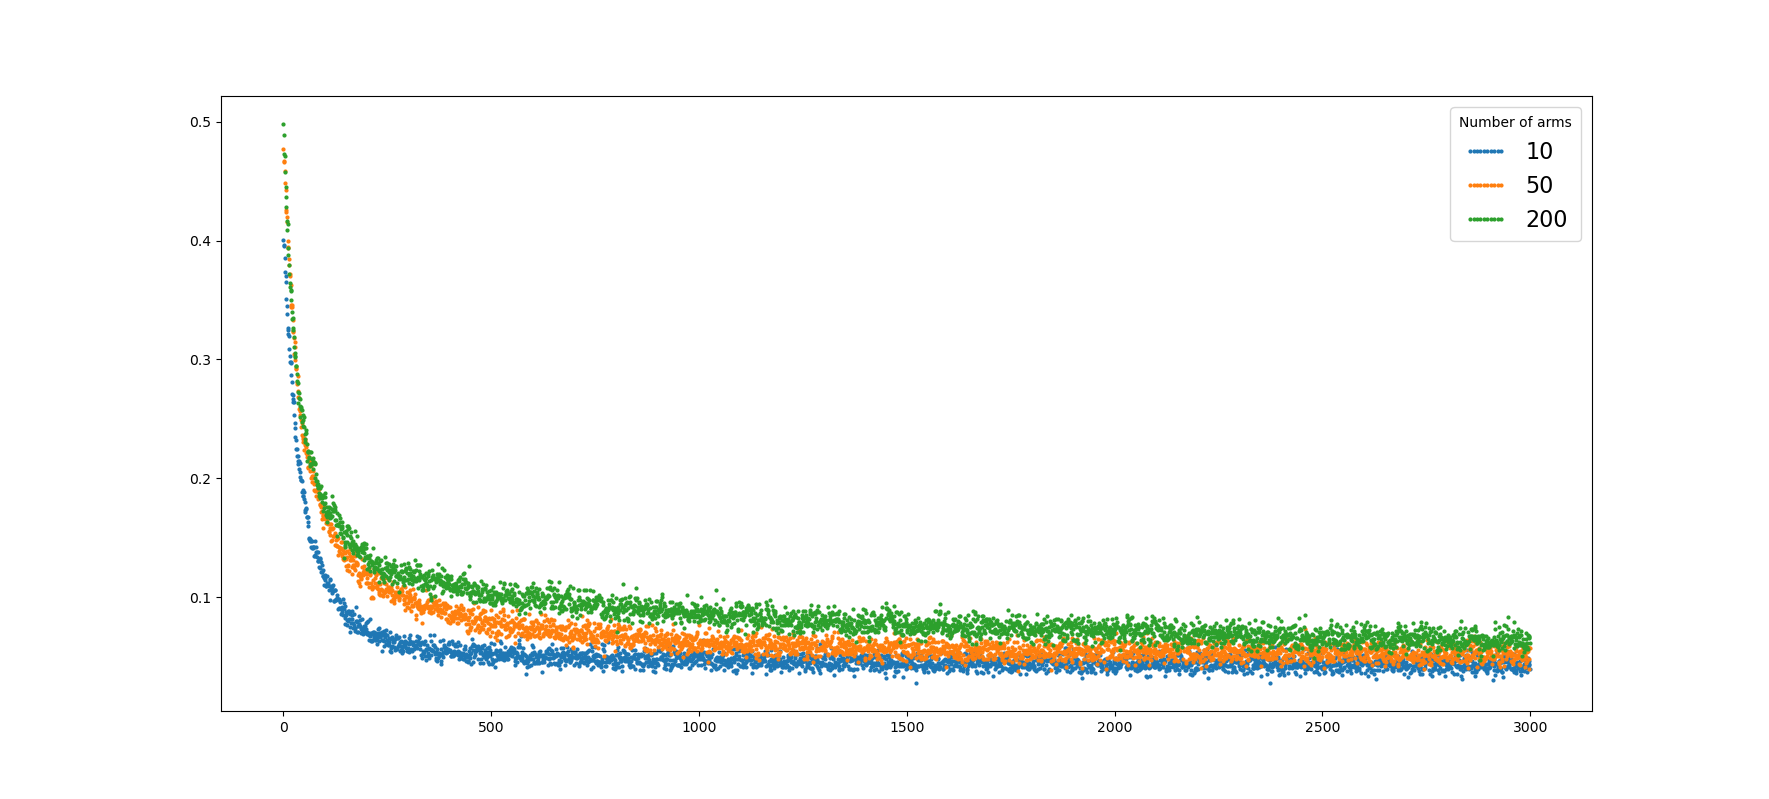



*    Upper Confidence Bound (UCB)


> As shown below, UCB’s performance is unstable as the number of arms increased, and the convergence time increases as well. Just like TS, UCB’s emphasis is on exploration, so when action space getting larger it takes longer for UCB to converge. However, unlike TS, UCB has a higher probability of taking suboptimal actions consistently as action space getting larger, which makes the performance of UCB dramatically unstable. Besides, the degree that action space affects UCB also depends on the hyperparameter c. If UCB agents are less optimistic (c =0.01) rather than overly optimistic (c =2), UCB will converge shortly since there is less over-exploration and higher probability to take an optimal action. Moreover, UCB even have a better result on large action space after fine tuning.




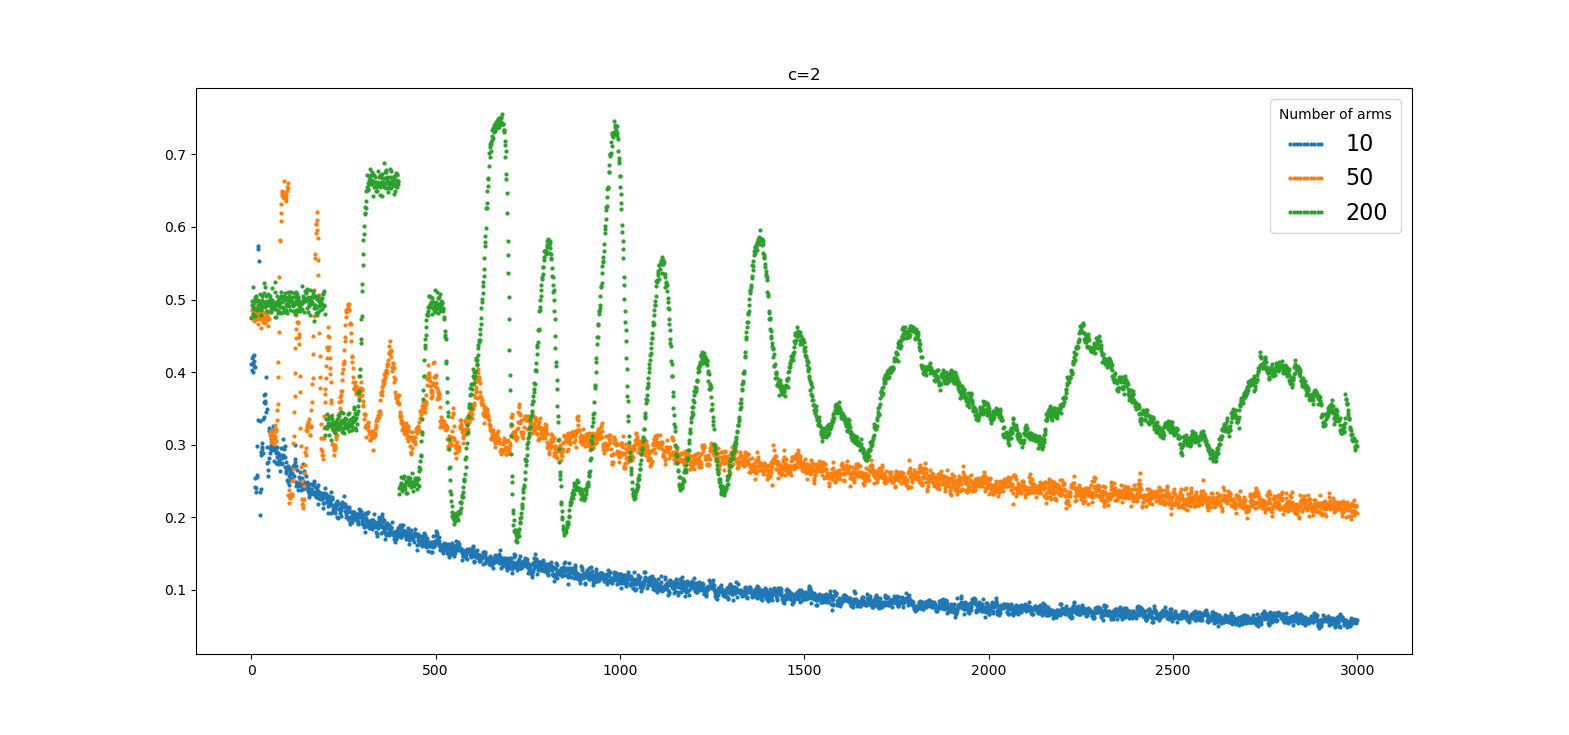
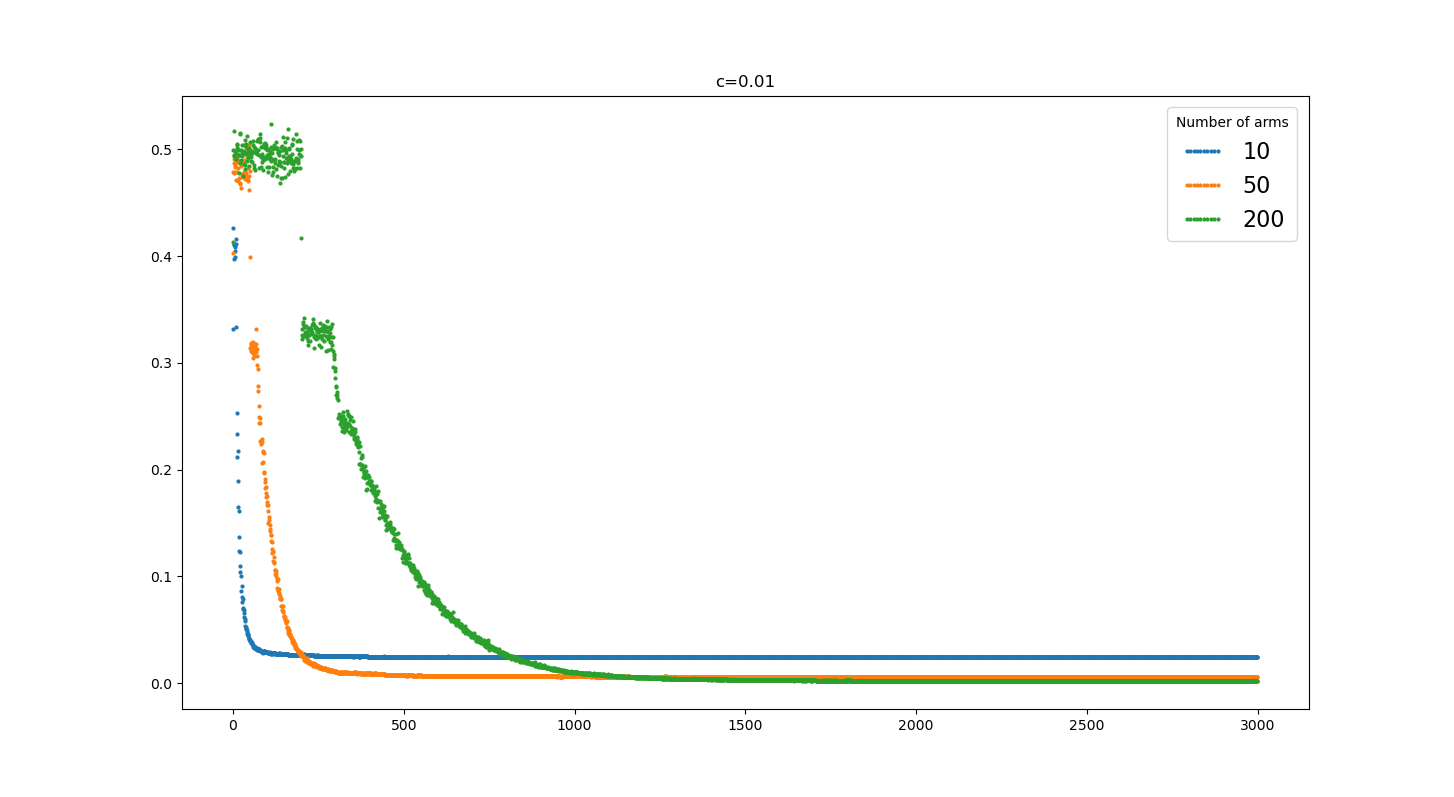



*   Random sampling


> As action space increasing, the regrets increase as well. Since RS just chooses actions randomly, the more actions to select the more difficult for it to select the best one.





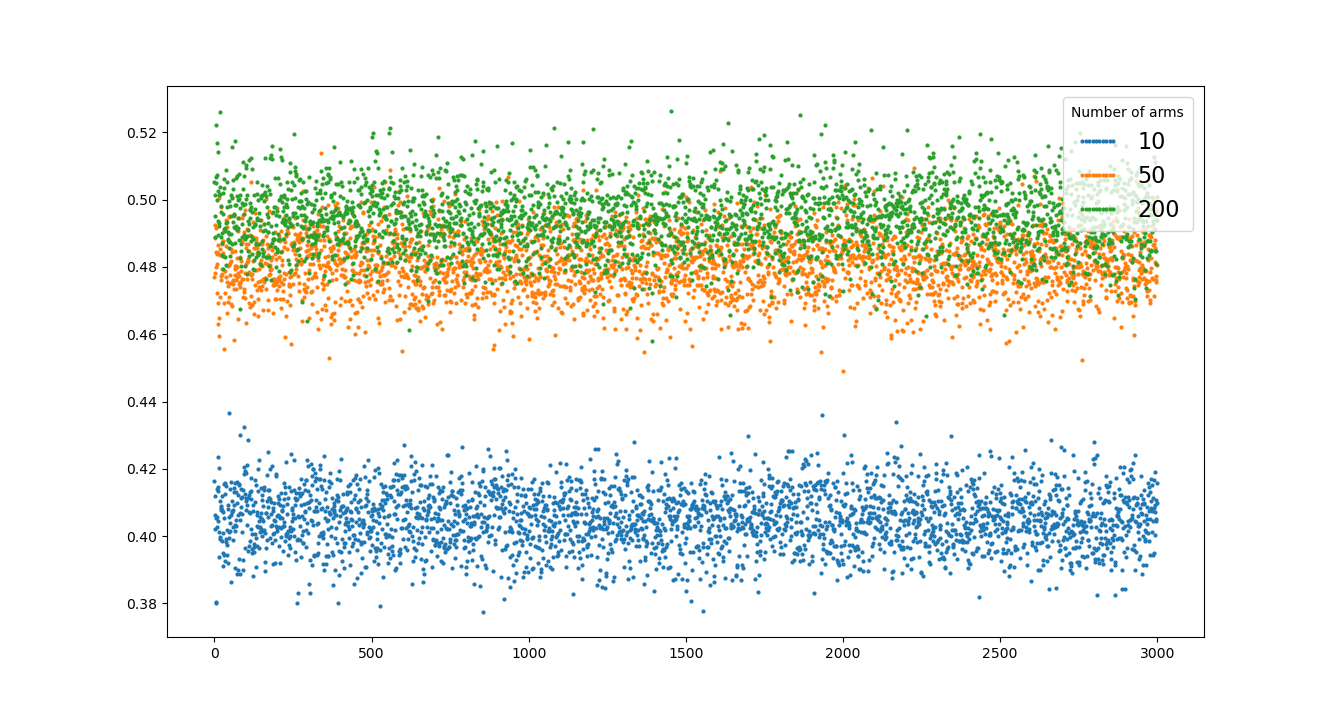

### 4.   Stationarity

In [ ]:
def stationarity(arm_count=10, algo=None, timesteps=1000, simulations=1000, title=''):
    global stationary
    stationers = [True, False]
    regrets = []
    names = []
    for s in stationers:
        stationary = s
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        if stationary:
            names.append('stationary')
        else:
            names.append('non-stationary')
    multi_plot_data(regrets, names, title2=algo.name() + ' ' + title)
    regrets.clear()
    names.clear()


def experiment4():
    global ucb_c, epsilon
    algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
    for algo in algos:
        if algo == UCB:
            for c in [2, 0.01]:
                ucb_c = c
                stationarity(algo=algo, title='c=' + str(c))
        elif algo == EpsilonGreedy:
            for e in [0.1, 0.5]:
                epsilon = e
                stationarity(algo=algo, title='e=' + str(e))
        else:
            stationarity(algo=algo)

In [ ]:
experiment4()



*   Thomphson Sampling

> As shown below, the regret of TS will jump back to original level every 100 steps due to non-stationary environment. Since the bandit will update true reward distribution periodically, TS agents need to re-explore periodically as well. Although the regret decreases quickly, it increases over time on average. Thus, TS does not perform well in a non-stationary environment.


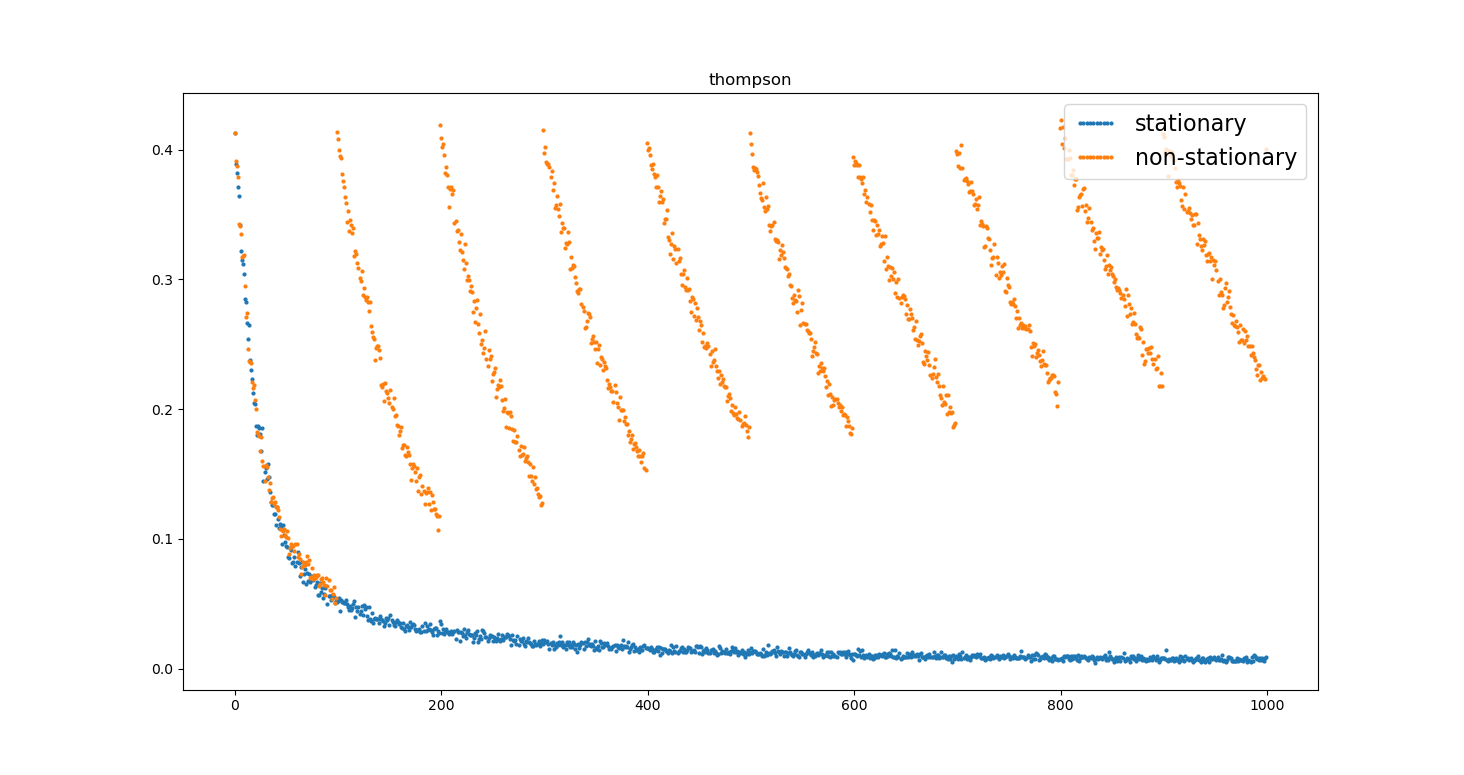

*   $\epsilon$-greedy


> For $\epsilon$-greedy, it performs similarly to TS but with higher variance due to some random actions (exploration). In a non-stationary environment, the agents prefer to explore will get a better result theoretically. However, when e-greedy agents become less greedy and more likely to explore (epsilon=0.5), they do not perform better as expected.




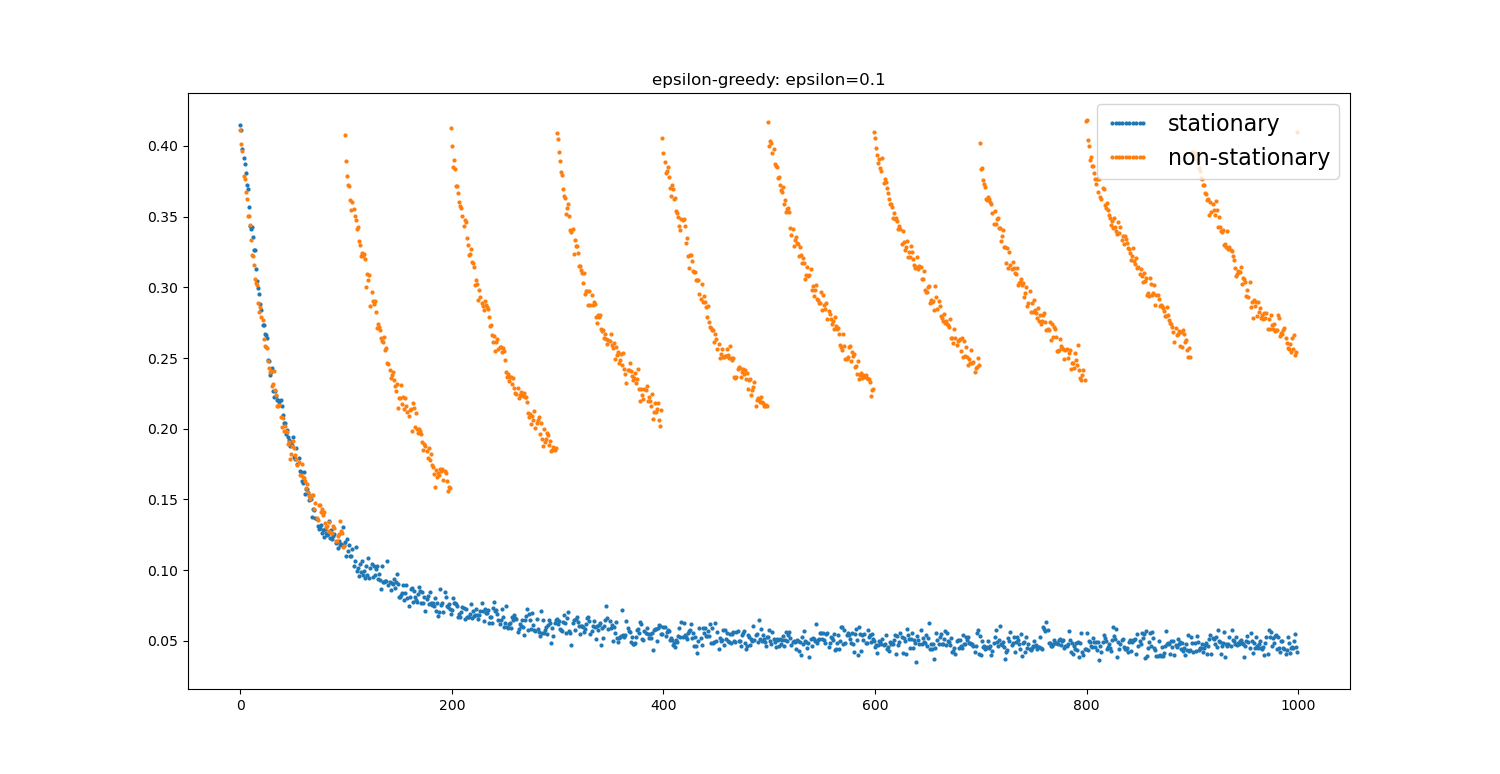

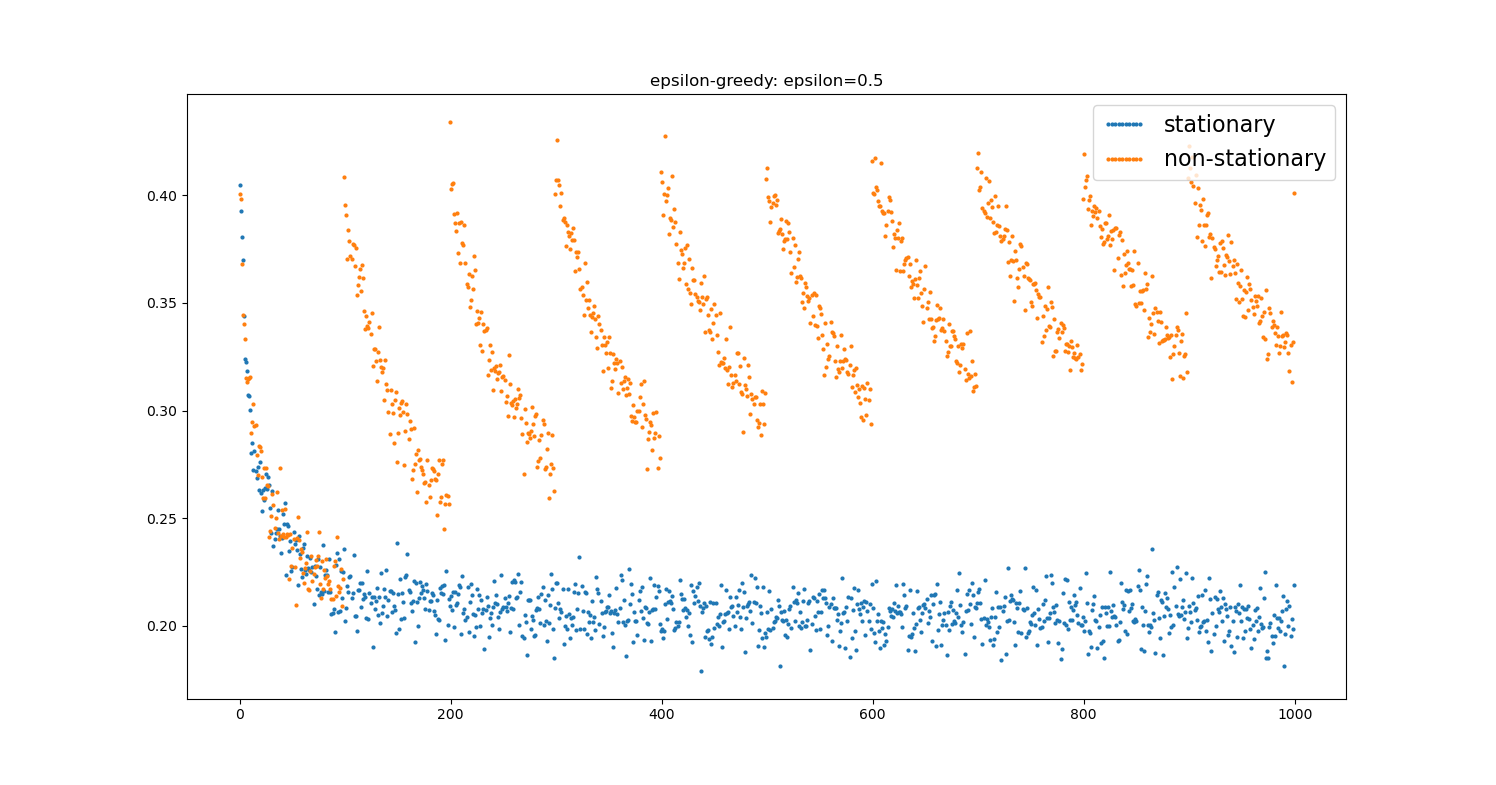



*    Upper Confidence Bound (UCB)


> As mentioned before, higher emphasis on exploration will lead to a better performance in non-stationary environment. It has been confirmed by the comparison shown below. The agents with more confidence decrease their regret more quickly and improve their performance step by step (regret is decreasing over time). And agents with less confidence (or greedier agents) perform like TS and e-greedy since they prefer to exploit the best action at present rather than explore other actions.




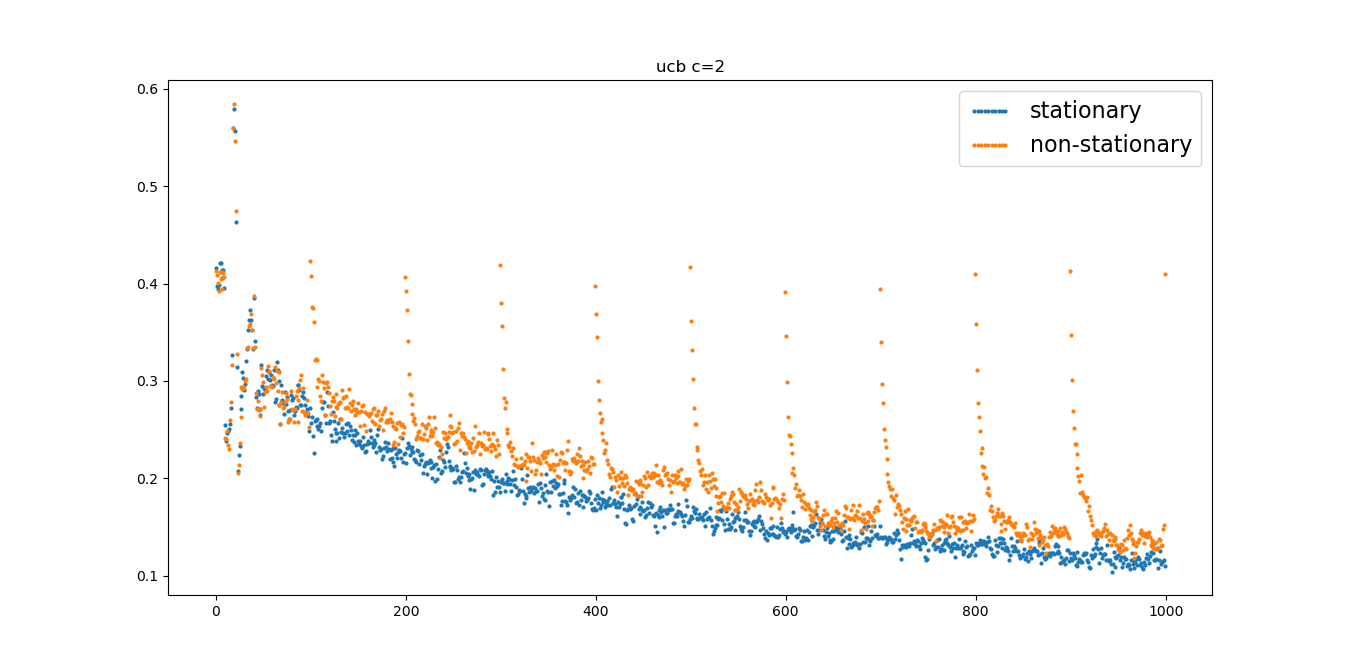

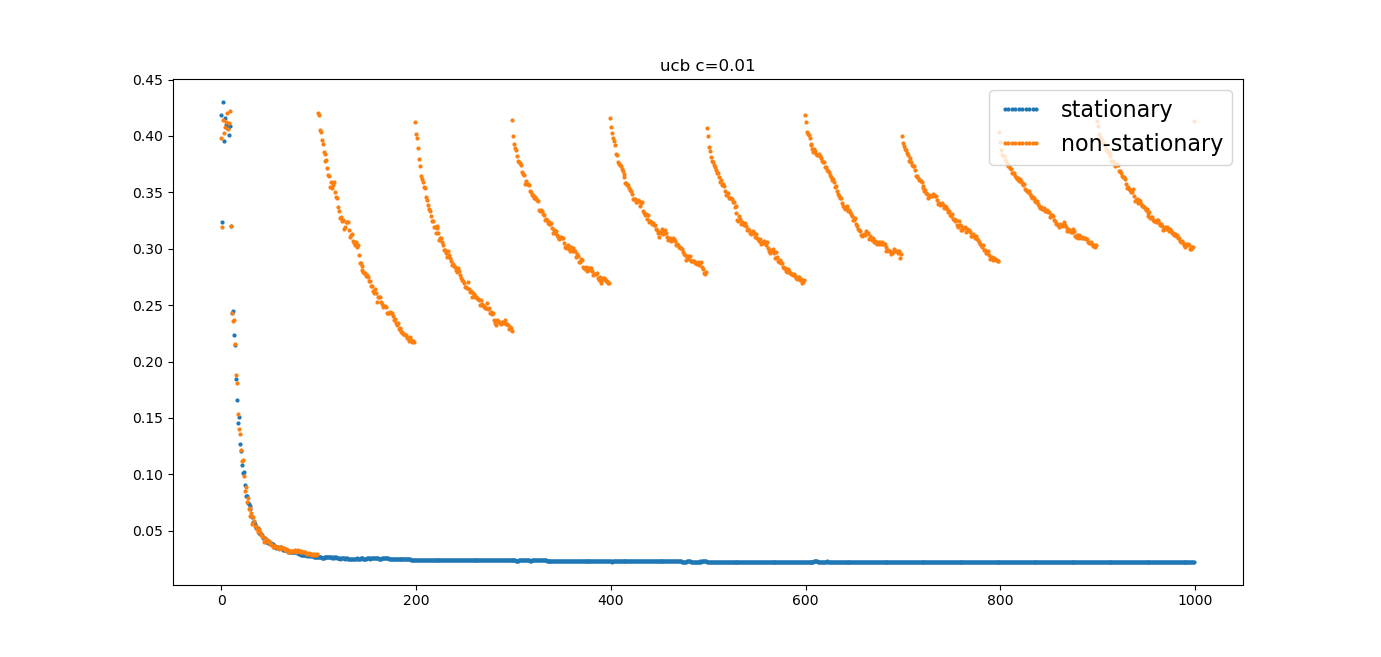



*   Random sampling


> The stationarity does not affect RS at all since it just chooses actions randomly.




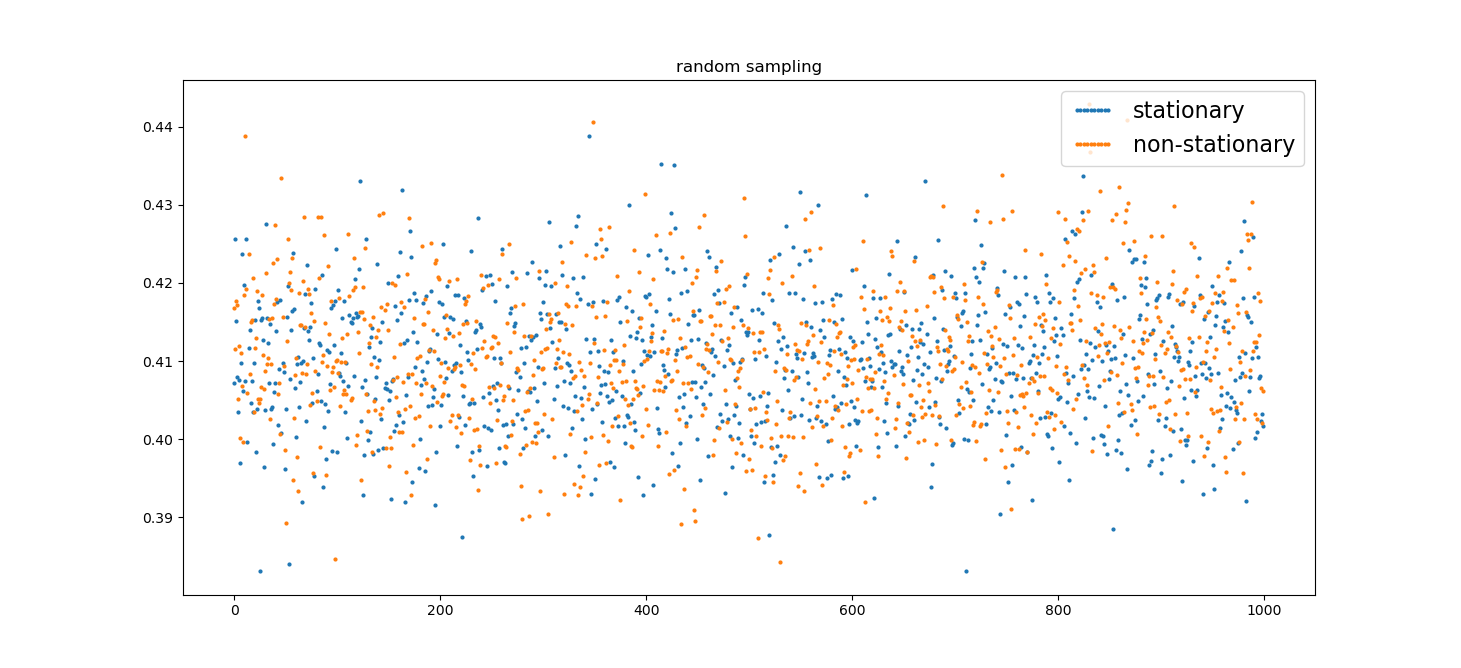

### 5.   When stop exploring? & exploration-exploitation tradeoff



*   Thomphson Sampling

> TS agent will stop exploring when it gets an optimal action in a stationary environment because the more it selects the optimal action, the more reward it gets, and the more reward this action gets, agent will be more likely to select this action (action’s posterior distribution is updated by reward received) just like positive feedback, which will end up with stop exploring and consistently select the optimal action.

*   $\epsilon$-greedy


> When epsilon=0, $\epsilon$-greedy agent will stop exploring once it gets the optimal action since there is no chance to do random action selections. Otherwise, when epsilon is not zero, e-greedy agent will never stop exploring because it is always possible to select some random actions (exploration).





*    Upper Confidence Bound (UCB)


> When UCB agent has zero confidence (c=0), it will also stop exploring once it gets the optimal action since it will always select the action with highest Q-value. Otherwise, when confidence is not zero and in a stationary environment, UCB agent will stop exploring when it finds an action that its Q-value is higher than those actions’ upper bound (Q-value plus potential) since it means there is no action will be better than this one.





*   Random sampling


> Random sampling will never stop exploring since all the actions are selected randomly.






*   Exploration-exploitation tradeoff


> Exploration-exploitation tradeoff in reinforcement learning happens where agents need to take advantage of past actions to find out how to get a reward effectively (exploitation), and they might also want to try other actions for better reward (exploration), but neither exploration nor exploitation can be done without expense, agents may not get the reward they expected. That is the tradeoff that agents need to consider—explore or exploit? Agents may get better reward after exploration but can also get a bad one. If agents just exploit consistently, they may not get the optimal reward.





### 6.   Past actions



*   Thomphson Sampling

> In TS, an action with highest mean reward will be chosen. And the reward is estimated by the action’s posterior distribution which at first is a uniform distribution (beta distribution with α=β=1) and will be updated by reward the action received. Thus, the action selection will be affected by previous actions, past actions will be remembered as a form of action’s posterior distribution till the end.


*   $\epsilon$-greedy and UCB


> Since e-greedy and UCB both take advantage of action-value method shown below estimating action values by the average reward of previous actions, they need to remember all the past actions to do so. Moreover, UCB will select actions that are less explored, if its agent has high confidence,so it should remember past actions to calculate uncertainity of actions to find out which actions are less explored.

$$
Q_t (a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{sum of time a taken prior to t}}
$$



*   Random sampling


> Random sampling will never remember its past actions because it just simply chooses an action to do randomly and does not take advantage of any past actions.





### 7.   TS with non-Beta distribution



*   Running TS with normal distribution.


> According to the character of two parameters ($\mu,\sigma$) in normal distribution, I let  $ \mu = \frac{\alpha}{\alpha + \beta}$ and $ \sigma = \frac{1}{\alpha + \beta}$ as update rule so that  actions' posterior distribution (normal distribution) can be updating better by reward received. When an action receives reward, $\mu$ will increase, which will increase this action's posterior probability, and vice versa. Moreover, $\sigma$ is constantly decreased throughout the simulation, which is reasonable that actions' posterior distribution becomes less spreaded as action selection goes.





In [ ]:
class BetaAlgo():
    """
    The algos try to learn which Bandit arm is the best to maximize reward.

    It does this by modelling the distribution of the Bandit arms with a Beta,
    assuming the true probability of success of an arm is Bernouilli distributed.
    """

    def __init__(self, bandit):
        """
        Args:
          bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)
        self.mu = np.ones(self.arm_count)
        self.sigma = np.ones(self.arm_count)

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward
        self.mu = self.alpha / (self.alpha + self.beta)
        self.sigma = 1 / (self.alpha + self.beta)



> Change np.random.beta(alpha, beta) to np.random.normal(mu, sigma).



In [ ]:
class BernThompson2(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson with normal distribution'

    def get_action(self):
        """ Bernouilli parameters are sampled from the normal"""
        theta = np.random.normal(self.mu, self.sigma)
        return theta.argmax()



> Compare Thomphson sampling by different distributions.


In [ ]:
def experiment5(arm_count=10, timesteps=1000, simulations=1000):
    algos = [BernThompson, BernThompson2]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

In [ ]:
experiment5()

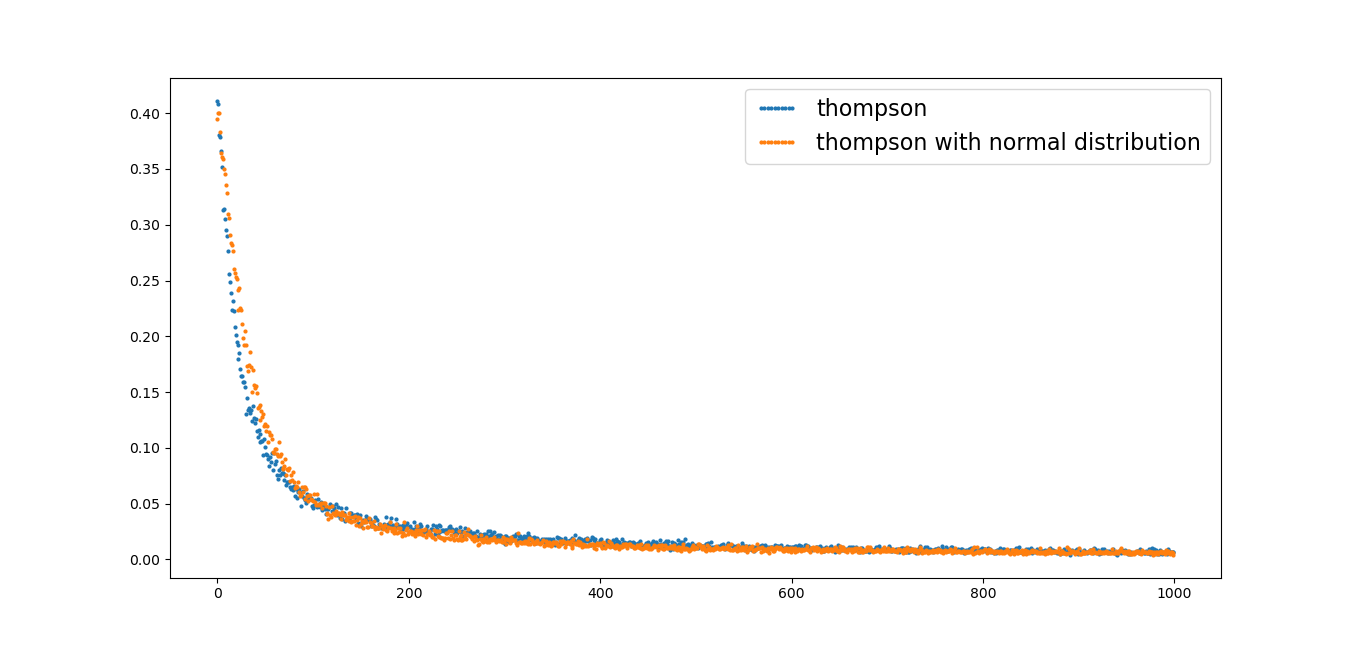

## Conclusion


*   Hyperparameters matter for TS, $\epsilon$-greedy and UCB are prior distribution of each arm's reward, epsilon $\epsilon$ and confidence c.
*   Action space did affect all those algorithms, and UCB's performance is affected most when it has large c.
*   In a non-stationary environment, TS and $\epsilon$-greedy's performance became worse, UCB performed best with appropriate c.





## Reference


1.   Andre Cianflone - Thompson Sampling. [link](https://colab.research.google.com/drive/1BHVH712x2Q2As9E5nN5Y8UR74T8w6AMO)
2.   Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017). [link](https://arxiv.org/abs/1707.02038)
3.   Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.
4.   Nicholas Brown - Reinforcement Learning : Thompson Sampling & the Multi-Armed Bandit Problem. [link](https://colab.research.google.com/drive/1gdR7k7jtSRqYnPNHcbAKdIjGRjQXpfnA)




## License
Copyright 2021 Gan Li

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.